# Projet 6 : Classifiez automatiquement des biens de consommation

Après avoir démontré la faisabilité de regrouper automatiquement des produits de même catégorie, notre objectif est désormais de réaliser une classification supervisée à partir des images. 

On décidera ici de mettre en oeuvre des modèles à partir de modèles pré-entraînés. Nous compléterons donc ces modèles pré-entraînés afin qu'ils répondent à notre problématique. Nous testerons plusieurs modèles différents avant de sélectionner celui qui semblera le plus pertinent pour notre problématique.

# Classification supervisée à partir des images

<a id="0"></a> <br>
# Table of Contents 

1. [Première approche : Mobilenet](#1)
2. [Deuxième approche : VGG16](#2)
3. [Troisième approche : Resnet50](#3)
4. [Optimisation du modèle choisi](#4)
5. [Data augmentation](#5)
  * [5.1 Images avec rotation](#6)
  * [5.2 Images avec shift](#7)
  * [5.3 Images avec zoom](#8)
  * [5.4 Images avec plusieurs transformations](#9)

In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
from plot_keras_history import show_history, plot_history

import P6_fonctions as fc
import importlib
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn import metrics
import pickle

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
np.random.seed(42)

In [4]:
importlib.reload(fc)

<module 'P6_fonctions' from '/Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 6/à zip/P6_fonctions.py'>

In [5]:
# FONCTIONS 

def create_model_fct(model0, loss = "categorical_crossentropy", opti='rmsprop', option = True) :
    '''Création du modèle adapté à notre objectif de classification 
    en modifiant le modèle pré-entraîné passé en paramètre.'''
    
    # On garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    
    # Compléter le modèle pour qu'il fournisse les probabilités d'appartenir aux 7 catégories.
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # Compilation du modèle 
    model.compile(loss=loss, optimizer=opti, metrics=["accuracy"])

    if option == True :
        print(model.summary())
    
    return model
    
def image_prep_fct(list_photos, model=None) :
    '''Préparation des images pour la modélisation.'''
    
    prepared_images = []
    
    for image_num in range(len(list_photos)) :
        img = (load_img(
            path_images + list_photos[image_num], 
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        if model == 'ResNet50':
            img = resnet50.preprocess_input(img)
        elif model == 'MobileNetV2':
            img = mobilenet_v2.preprocess_input(img)
        else :
            img = vgg16.preprocess_input(img)

        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)

    return prepared_images_np

def plot_hist(hist) :
    '''Affichage de la loss et de l'accuracy en fonction des epochs.'''
    show_history(hist)
    plot_history(hist)
    plt.close()

def data_flow_fct(data, datagen, data_type=None) :
    '''Génère des lots de données augmentées.'''
    
    data_flow = datagen.flow_from_dataframe(data, directory=path_images,
                                x_col='image', y_col='label',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [6]:
df_cat = pd.read_csv('data_text_clean.csv')

In [8]:
df_cat.head()

,Unnamed: 0,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,...,cat_3,label,descr_bow,length_bow,descr_bow_lem,length_bow_lem,descr_bow_stem,length_bow_stem,descr_dl,length_dl
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56+00:00,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,...,Curtains,4,key features elegance polyester multicolor abs...,156,key feature elegance polyester multicolor abst...,156,key featur eleg polyest multicolor abstract ey...,156,key features of elegance polyester multicolor ...,248
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56+00:00,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,...,Baby Bath Towels,0,specifications sathiyas cotton bath towel bath...,63,specification sathiyas cotton bath towel bath ...,63,specif sathiya cotton bath towel bath towel re...,63,specifications of sathiyas cotton bath towel (...,84
2,2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56+00:00,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,...,Baby Bath Towels,0,key features eurospa cotton terry face towel s...,158,key feature eurospa cotton terry face towel se...,158,key featur eurospa cotton terri face towel set...,158,key features of eurospa cotton terry face towe...,253
3,3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52+00:00,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,...,Bedsheets,4,key features santosh royal fashion cotton prin...,114,key feature santosh royal fashion cotton print...,114,key featur santosh royal fashion cotton print ...,114,key features of santosh royal fashion cotton p...,151
4,4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52+00:00,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,...,Bedsheets,4,key features jaipur print cotton floral king s...,156,key feature jaipur print cotton floral king si...,156,key featur jaipur print cotton floral king siz...,156,key features of jaipur print cotton floral kin...,232


In [7]:
liste_cat = ['Baby Care','Beauty and Personal Care','Computers','Home Decor & Festive Needs',
            'Home Furnishing','Kitchen & Dining','Watches']

In [8]:
path_images = "Flipkart/Images/"
list_photos = [file for file in listdir(path_images)]

In [13]:
pd.DataFrame(df_cat['image']).shape

(1050, 1)

# <a id="1"></a> 1. Première approche : Mobilenet

MobileNet est une architecture de réseau de neurones convolutifs (CNN) conçue pour les appareils mobiles et les applications de vision par ordinateur embarquées. Il utilise une combinaison de convolutions profondes et de convolutions à noyau séparable pour réduire le nombre de paramètres du modèle tout en préservant la précision de la classification. 

Ici nous utiliserons MobileNetV2. C'est une version améliorée de MobileNet, un réseau de neurones convolutif utilisé pour la classification d'images. Il est conçu pour être rapide et efficace en termes de puissance de calcul et de mémoire.

In [45]:
# Séparation du jeu de données en jeu de train et de test
X_train_mob, X_test_mob, y_train_mob, y_test_mob = train_test_split(df_cat['image'], df_cat['label'], test_size=0.2, random_state=0)
print(X_train_mob.shape)
print(y_train_mob.shape)
print(X_test_mob.shape)
print(y_test_mob.shape)

(840,)
(840,)
(210,)
(210,)


In [46]:
X_train_mob = list(X_train_mob)
X_test_mob = list(X_test_mob)

In [47]:
# Traitement des images pour les rendre exploitables par l'algorithme
images_np = image_prep_fct(X_train_mob,'MobileNetV2')
print(images_np.shape)
images_np_test = image_prep_fct(X_test_mob, 'MobileNetV2')
print(images_np_test.shape)

(840, 224, 224, 3)


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(210, 224, 224, 3)


In [48]:
X_mob = images_np
y_mob = to_categorical(y_train_mob)

X_test_mob = images_np_test
y_test_mob = to_categorical(y_test_mob)

y_mob

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [49]:
# Séparation du jeu de train en jeu de train et de validation
X_train_mob, X_val_mob, y_train_mob, y_val_mob = train_test_split(X_mob, y_mob, stratify=y_mob, test_size=0.25, random_state=0)
X_train_mob.shape

(630, 224, 224, 3)

In [50]:
# Création du modèle
# Charger le modèle pré-entraîné sur ImageNet, sans les couches fully-connected
model = mobilenet_v2.MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

model2 = create_model_fct(model)

# Création du callback
model2_save_path1 = "models/model2_mobilenet_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                            

 ization)                                                                                         
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
          

 block_10_depthwise_BN (BatchNo  (None, 14, 14, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_

 block_14_expand_relu (ReLU)    (None, 7, 7, 960)    0           ['block_14_expand_BN[0][0]']     
                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_

In [51]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1=time.time()

history2 = model2.fit(X_train_mob, y_train_mob, epochs=50, batch_size=64, 
                      callbacks=callbacks_list, validation_data=(X_val_mob, y_val_mob), verbose=1)

temps2_train_mob = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_mob))

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.4309 - accuracy: 0.5381
Epoch 1: val_loss improved from inf to 0.79872, saving model to models/model2_mobilenet_best_weights.h5
10/10 [==============================] - 16s 1s/step - loss: 1.4309 - accuracy: 0.5381 - val_loss: 0.7987 - val_accuracy: 0.7619
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.5342 - accuracy: 0.8270
Epoch 2: val_loss improved from 0.79872 to 0.61395, saving model to models/model2_mobilenet_best_weights.h5
10/10 [==============================] - 7s 724ms/step - loss: 0.5342 - accuracy: 0.8270 - val_loss: 0.6139 - val_accuracy: 0.8286
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.4148 - accuracy: 0.8476
Epoch 3: val_loss improved from 0.61395 to 0.59542, saving model to models/model2_mobilenet_best_weights.h5
10/10 [==============================] - 7s 765ms/step - loss: 0.4148 - accuracy: 0.8476 - val_loss: 0.5954 - val_accuracy: 0.8143
Epoch 4

Après avoir entrainé le modèle, nous allons évaluer les scores de celui-ci.

On s'intéresse ici à l'accuracy et à la loss. 
L'accuracy est une métrique qui mesure la performance d'un modèle de classification. Elle représente la proportion de prédictions correctes faites par le modèle.
La loss est une mesure qui permet d'évaluer la qualité des prédictions d'un modèle par rapport à la réalité. Elle mesure l'écart entre les prédictions du modèle et les valeurs réelles de la variable cible. Le but est de minimiser cette fonction de perte pour améliorer les performances du modèle.

Nous utiliserons ces métriques afin de comparer nos différents modèles.

In [53]:
# Scores du dernier epoch

loss_train, accuracy_train = model2.evaluate(X_train_mob, y_train_mob, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy_train))
print()
loss, accuracy = model2.evaluate(X_val_mob, y_val_mob, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 2s 100ms/step - loss: 0.0171 - accuracy: 1.0000
Training Accuracy: 1.0000

7/7 [==============================] - 1s 105ms/step - loss: 0.6577 - accuracy: 0.8286
Validation Accuracy:  0.8286


On évalue les scores de l'epoch enregistré comme optimal lors de l'entraînement. 

In [54]:
# Scores de l'epoch optimal

model2.load_weights(model2_save_path1)

loss_train_mob, accuracy_train_mob = model2.evaluate(X_train_mob, y_train_mob, verbose=False)
print("Training Accuracy :  {:.4f}".format(accuracy_train_mob))

temps1=time.time()

loss_val_mob, accuracy_val_mob = model2.evaluate(X_val_mob, y_val_mob, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_mob))

temps2_val_mob = np.round(time.time()-temps1, 2)
print("Temps validation : {} secondes".format(temps2_val_mob))

temps1=time.time()

loss_test_mob, accuracy_test_mob = model2.evaluate(X_test_mob, y_test_mob, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_mob))

temps2_test_mob = np.round(time.time()-temps1, 2)
print("Temps test : {} secondes".format(temps2_test_mob))

Training Accuracy :  0.9619
Validation Accuracy :  0.8143
Temps validation : 1.93 secondes
Test Accuracy       :  0.8048
Temps test : 2.01 secondes


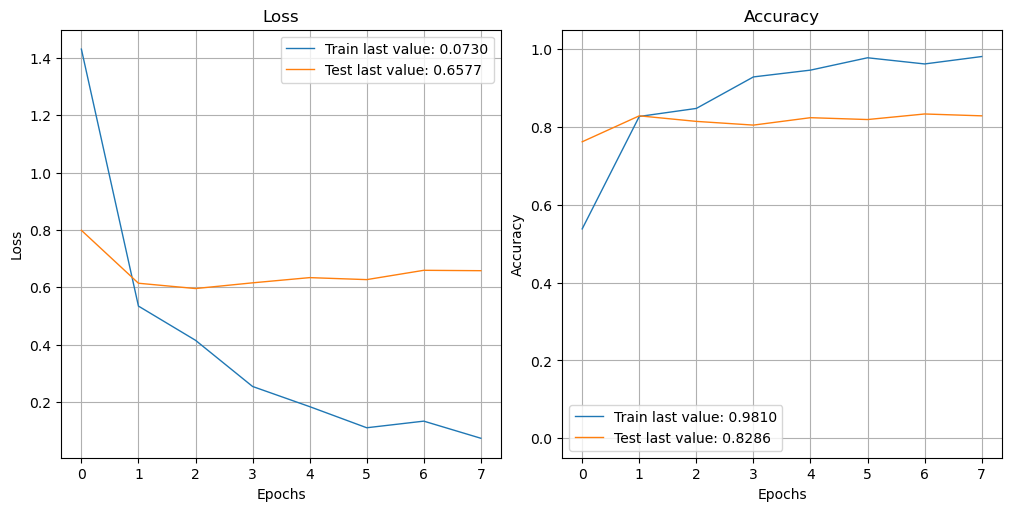

In [55]:
plot_hist(history2)

On collecte l'historique renvoyé par l'entraînement du modèle et on crée deux graphiques : l'un représentant l'accuracy sur les ensembles de données de training et de validation sur les différents epochs, et l'autre similaire mais pour la loss.
L'objectif étant pour chaque modèle de maximiser l'accuracy tout en diminuant la loss. 

Notre epoch optimal correspond à l'epoch 2 sur les graphiques. On peut constater qu'au delà, le modèle semble être dans un phénomène d'overfitting. 

In [56]:
y_val_num = np.argmax(y_val_mob, axis=1)
y_val_pred = np.argmax(model2.predict(X_val_mob), axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 4s 457ms/step
[0 1 0 0 2 2 3 5 5 2 3 2 2 5 2 2 5 4 4 6 5 4 5 3 3 2 3 3 6 5 6 5 6 6 2 6 4
 6 5 4 0 0 3 5 6 6 2 5 4 6 0 1 6 1 2 4 1 0 3 3 3 6 5 5 5 1 1 3 3 0 4 1 3 0
 6 2 3 1 2 4 1 4 4 4 1 6 0 0 2 4 0 6 3 4 6 5 2 0 6 0 3 6 0 2 6 0 1 5 1 2 0
 4 5 6 5 5 2 1 6 1 4 4 5 1 4 3 3 2 0 6 5 5 0 2 2 3 5 3 3 2 4 4 3 2 4 3 2 6
 5 6 1 3 3 4 0 0 6 0 1 1 5 3 1 1 1 0 4 6 0 3 1 3 1 4 4 4 1 0 6 4 2 2 1 2 6
 0 5 5 1 4 5 5 3 2 2 3 0 5 2 3 1 2 5 1 0 5 6 1 4 1]

[0 1 0 0 2 2 3 5 5 2 3 2 2 5 2 2 5 4 4 6 5 4 5 3 3 2 3 3 6 5 6 5 6 6 2 6 4
 6 5 4 0 4 3 5 6 6 2 2 0 6 0 4 6 1 2 4 1 0 3 3 3 6 2 5 0 1 1 3 4 3 4 2 3 0
 6 2 3 1 2 0 1 4 4 4 2 6 0 0 1 4 0 6 3 4 6 1 2 4 6 0 3 6 0 1 6 0 4 3 1 2 0
 4 5 1 2 5 2 1 6 1 4 4 5 3 0 3 3 2 4 6 5 5 0 1 2 3 5 0 3 2 4 4 3 1 4 3 2 6
 5 6 3 5 4 4 4 0 6 0 1 1 5 3 1 1 1 5 4 6 0 3 1 4 1 4 4 4 1 0 1 4 2 2 1 2 6
 5 1 5 2 4 5 0 3 2 3 3 0 2 2 5 1 2 5 1 0 5 6 1 4 1]


In [57]:
conf_mat2 = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat2)

[[21  0  0  1  4  2  0]
 [ 0 23  3  2  2  0  0]
 [ 0  4 26  1  0  0  0]
 [ 1  0  0 25  3  2  0]
 [ 3  0  0  0 26  0  0]
 [ 2  2  4  1  0 23  0]
 [ 0  2  0  0  0  0 27]]


In [58]:
corresp = 'argmax'
y_val_pred_transform2 = fc.conf_mat_transform(y_val_num, y_val_pred, corresp)
conf_mat2 = metrics.confusion_matrix(y_val_num, y_val_pred_transform2)
print(conf_mat2)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform2))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[21  0  0  1  4  2  0]
 [ 0 23  3  2  2  0  0]
 [ 0  4 26  1  0  0  0]
 [ 1  0  0 25  3  2  0]
 [ 3  0  0  0 26  0  0]
 [ 2  2  4  1  0 23  0]
 [ 0  2  0  0  0  0 27]]

              precision    recall  f1-score   support

           0       0.78      0.75      0.76        28
           1       0.74      0.77      0.75        30
           2       0.79      0.84      0.81        31
           3       0.83      0.81      0.82        31
           4       0.74      0.90      0.81        29
           5       0.85      0.72      0.78        32
           6       1.00      0.93      0.96        29

    accuracy                           0.81       210
   macro avg       0.82      0.82      0.82       210
weighted avg       0.82      0.81      0.81       210



<Axes: >

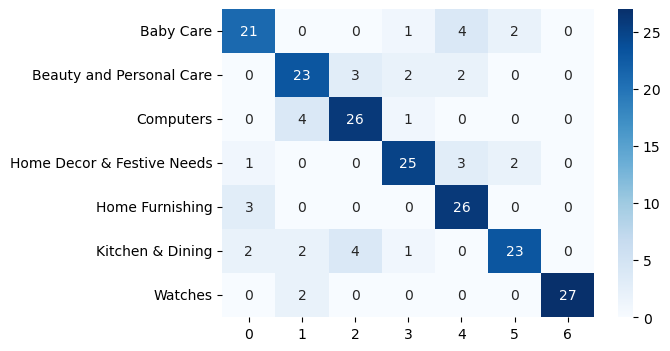

In [59]:
df_cm2 = pd.DataFrame(conf_mat2, index = [label for label in liste_cat],
                      columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm2, annot=True, cmap="Blues")

On constate que le modèle arrive à prédire relativement bien les catégories. En revanche, il y a des erreurs. Certaines images sont mal catégorisées. Seule la catégorie *Watches* ne comporte aucune erreur.


# <a id="2"></a> 2. Deuxième approche : VGG16

Nous utilisons de nouveau le modèle VGG16, utilisé dans le notebook précédent afin d'extraire des features et ainsi prouver la faisabilité de la classification. Nous l'utilisons désormais à des fins de classification. C'est pourquoi, comme pour le première approche, nous utilisons le modèle pré-entraîné et modifions les dernières couches dites fully-connected afin de fournir les probabilités d'appartenance à nos 7 catégories de produit.

In [29]:
# Séparation du jeu de données en jeu de train et de test
X_train, X_test, y_train, y_test = train_test_split(df_cat['image'], df_cat['label'], test_size=0.2, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(840,)
(840,)
(210,)
(210,)


In [30]:
X_train = list(X_train)
X_test = list(X_test)

In [31]:
# Traitement des images pour les rendre exploitables par l'algorithme 
images_np = image_prep_fct(X_train, 'VGG16')
print(images_np.shape)
images_np_test = image_prep_fct(X_test,'VGG16')
print(images_np_test.shape)

(840, 224, 224, 3)


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(210, 224, 224, 3)


In [32]:
X = images_np
y = to_categorical(y_train)

X_test = images_np_test
y_test = to_categorical(y_test)

y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
# Séparation du jeu de train en jeu de train et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)
X_train.shape

(630, 224, 224, 3)

In [36]:
# Création du modèle
# Charger le modèle pré-entraîné sur ImageNet, sans les couches fully-connected
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

model1 = create_model_fct(model)

# Création du callback
model1_save_path1 = "models/model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [37]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1=time.time()

history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                      callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

temps2_train_vgg = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_vgg))

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 5.7803 - accuracy: 0.4365
Epoch 1: val_loss improved from inf to 1.30316, saving model to models/model1_best_weights.h5
10/10 [==============================] - 31s 3s/step - loss: 5.7803 - accuracy: 0.4365 - val_loss: 1.3032 - val_accuracy: 0.7762
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.9995 - accuracy: 0.6730
Epoch 2: val_loss improved from 1.30316 to 1.10590, saving model to models/model1_best_weights.h5
10/10 [==============================] - 28s 3s/step - loss: 1.9995 - accuracy: 0.6730 - val_loss: 1.1059 - val_accuracy: 0.8190
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.2518 - accuracy: 0.7571
Epoch 3: val_loss improved from 1.10590 to 1.09093, saving model to models/model1_best_weights.h5
10/10 [==============================] - 29s 3s/step - loss: 1.2518 - accuracy: 0.7571 - val_loss: 1.0909 - val_accuracy: 0.8143
Epoch 4/50
10/10 [=======================

In [60]:
# Scores du dernier epoch

loss_train, accuracy_train = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy_train_vgg))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 17s 820ms/step - loss: 0.0227 - accuracy: 0.9952
Training Accuracy: 0.9968

7/7 [==============================] - 6s 816ms/step - loss: 0.7586 - accuracy: 0.8619
Validation Accuracy:  0.8619


In [62]:
# Scores de l'epoch optimal

model1.load_weights(model1_save_path1)

loss_train_vgg, accuracy_train_vgg = model1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_train_vgg))

temps1=time.time()

loss_val_vgg, accuracy_val_vgg = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_vgg))

temps2_val_vgg = np.round(time.time()-temps1, 2)
print("Temps validation : {} secondes".format(temps2_val_vgg))

temps1=time.time()

loss_test_vgg, accuracy_test_vgg = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_vgg))

temps2_test_vgg = np.round(time.time()-temps1, 2)
print("Temps test : {} secondes".format(temps2_test_vgg))

Training Accuracy: 0.9952
Validation Accuracy :  0.8619
Temps validation : 5.44 secondes
Test Accuracy       :  0.7810
Temps test : 5.41 secondes


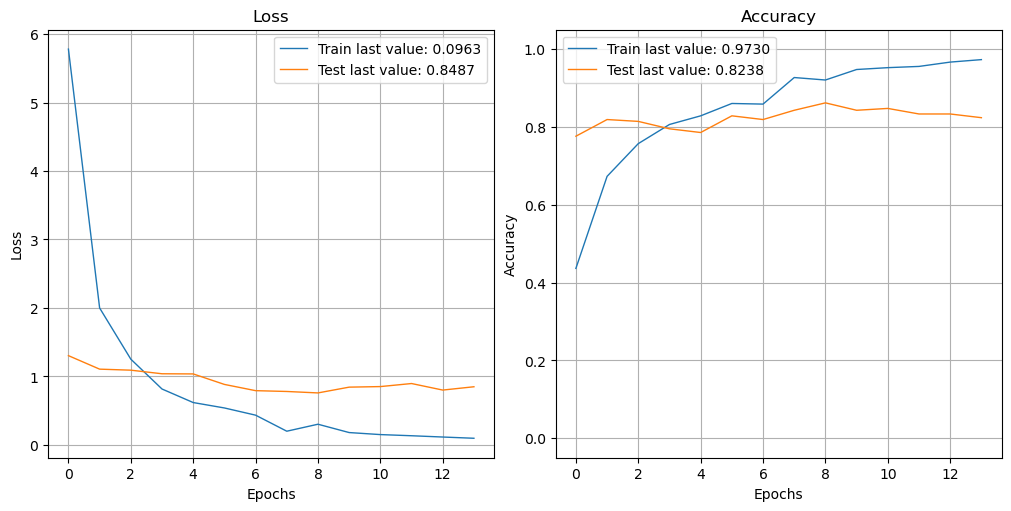

In [40]:
plot_hist(history1)

On collecte l'historique renvoyé par l'entraînement du modèle et on crée deux graphiques : l'un représentant l'accuracy sur les ensembles de données de training et de validation sur les différents epochs, et l'autre similaire mais pour la loss. L'objectif étant pour chaque modèle de maximiser l'accuracy tout en diminuant la loss.

Notre epoch optimal correspond à l'epoch 8 sur les graphiques. On peut constater qu'au delà, le modèle semble être dans un phénomène de léger overfitting.

In [41]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 6s 968ms/step
[0 1 0 0 2 2 3 5 5 2 3 2 2 5 2 2 5 4 4 6 5 4 5 3 3 2 3 3 6 5 6 5 6 6 2 6 4
 6 5 4 0 0 3 5 6 6 2 5 4 6 0 1 6 1 2 4 1 0 3 3 3 6 5 5 5 1 1 3 3 0 4 1 3 0
 6 2 3 1 2 4 1 4 4 4 1 6 0 0 2 4 0 6 3 4 6 5 2 0 6 0 3 6 0 2 6 0 1 5 1 2 0
 4 5 6 5 5 2 1 6 1 4 4 5 1 4 3 3 2 0 6 5 5 0 2 2 3 5 3 3 2 4 4 3 2 4 3 2 6
 5 6 1 3 3 4 0 0 6 0 1 1 5 3 1 1 1 0 4 6 0 3 1 3 1 4 4 4 1 0 6 4 2 2 1 2 6
 0 5 5 1 4 5 5 3 2 2 3 0 5 2 3 1 2 5 1 0 5 6 1 4 1]

[0 1 0 0 2 2 3 5 5 2 3 2 2 5 2 2 5 4 4 6 5 4 5 3 3 2 3 3 6 5 6 5 6 4 2 2 4
 6 5 4 0 4 3 5 6 6 2 5 0 6 0 2 6 1 2 4 1 0 3 6 3 6 2 6 5 1 1 3 3 2 4 2 3 0
 6 2 3 1 2 0 1 0 4 0 2 6 0 0 2 4 0 6 3 4 6 5 2 0 6 0 3 6 0 2 6 0 4 5 1 2 0
 4 5 6 5 5 2 3 6 1 4 4 5 1 4 3 3 2 0 6 5 5 0 2 2 3 5 3 3 2 4 4 3 2 4 3 2 6
 5 6 3 3 3 4 0 0 5 0 1 1 5 3 1 3 1 5 4 6 0 3 1 1 1 4 4 4 1 0 6 4 2 1 1 2 6
 5 3 5 2 4 5 5 3 2 3 2 0 5 2 5 1 2 5 1 0 5 6 2 4 1]


In [42]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[24  0  1  0  1  2  0]
 [ 0 21  5  3  1  0  0]
 [ 0  1 29  1  0  0  0]
 [ 0  1  1 27  0  1  1]
 [ 4  0  0  0 25  0  0]
 [ 0  0  1  1  0 29  1]
 [ 0  0  1  0  1  1 26]]


In [43]:
corresp = 'argmax'
y_val_pred_transform = fc.conf_mat_transform(y_val_num, y_val_pred, corresp)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[24  0  1  0  1  2  0]
 [ 0 21  5  3  1  0  0]
 [ 0  1 29  1  0  0  0]
 [ 0  1  1 27  0  1  1]
 [ 4  0  0  0 25  0  0]
 [ 0  0  1  1  0 29  1]
 [ 0  0  1  0  1  1 26]]

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        28
           1       0.91      0.70      0.79        30
           2       0.76      0.94      0.84        31
           3       0.84      0.87      0.86        31
           4       0.89      0.86      0.88        29
           5       0.88      0.91      0.89        32
           6       0.93      0.90      0.91        29

    accuracy                           0.86       210
   macro avg       0.87      0.86      0.86       210
weighted avg       0.87      0.86      0.86       210



<Axes: >

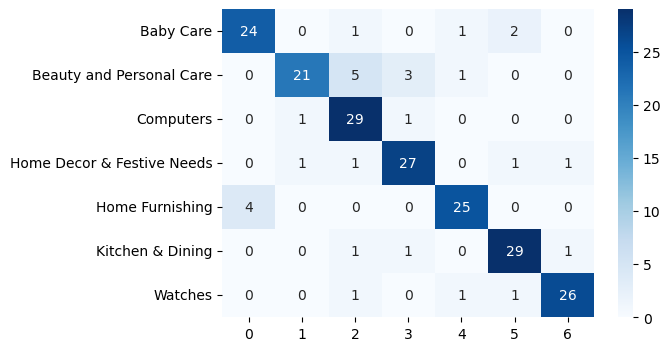

In [44]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

On constate que le modèle arrive à prédire relativement bien les catégories. En revanche, il y a des erreurs. Certaines images sont mal catégorisées. Il y a cependant moins d'erreurs que pour le modèle MobileNet.


# <a id="3"></a> 3. Troisième approche : Resnet50

ResNet50 (ou Residual Network) est un modèle de réseau de neurones convolutifs profonds (CNN) utilisé pour la classification d'images. La particularité de ResNet50 est qu'il utilise des connexions résiduelles qui permettent à l'information de contourner les couches intermédiaires du réseau. De la même manière que ses prédécesseurs, il a été pré-entraîné sur des millions d'images et peut être utilisé comme point de départ pour la tâche de classification d'images.

In [63]:
# Séparation du jeu de données en jeu de train et de test
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(df_cat['image'], df_cat['label'], test_size=0.2, random_state=0)
print(X_train_res.shape)
print(y_train_res.shape)
print(X_test_res.shape)
print(y_test_res.shape)

(840,)
(840,)
(210,)
(210,)


In [64]:
X_train_res = list(X_train_res)
X_test_res = list(X_test_res)

In [65]:
# Traitement des images pour les rendre exploitables par l'algorithme 
images_np = image_prep_fct(X_train_res,'ResNet50')
print(images_np.shape)
images_np_test = image_prep_fct(X_test_res, 'ResNet50')
print(images_np_test.shape)

(840, 224, 224, 3)


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(210, 224, 224, 3)


In [66]:
X_res = images_np
y_res = to_categorical(y_train_res)

X_test_res = images_np_test
y_test_res = to_categorical(y_test_res)

y_res

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [67]:
# Séparation du jeu de train en jeu de train et de validation
X_train_res, X_val_res, y_train_res, y_val_res = train_test_split(X_res, y_res, stratify=y_res, test_size=0.25, random_state=0)
X_train_res.shape

(630, 224, 224, 3)

In [68]:
# Création du modèle
# Charger le modèle pré-entraîné sur ImageNet, sans les couches fully-connected
model = resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

model3 = create_model_fct(model)

# Création du callback
model3_save_path1 = "models/model3_resnet50_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [69]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1=time.time()

history3 = model3.fit(X_train_res, y_train_res, epochs=50, batch_size=64, 
                      callbacks=callbacks_list, validation_data=(X_val_res, y_val_res), verbose=1)

temps2_train_res = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_res))

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 2.2228 - accuracy: 0.4873
Epoch 1: val_loss improved from inf to 0.77436, saving model to models/model3_resnet50_best_weights.h5
10/10 [==============================] - 24s 2s/step - loss: 2.2228 - accuracy: 0.4873 - val_loss: 0.7744 - val_accuracy: 0.7429
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.8063
Epoch 2: val_loss did not improve from 0.77436
10/10 [==============================] - 16s 2s/step - loss: 0.5809 - accuracy: 0.8063 - val_loss: 1.2961 - val_accuracy: 0.6857
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.4326 - accuracy: 0.8524
Epoch 3: val_loss improved from 0.77436 to 0.62436, saving model to models/model3_resnet50_best_weights.h5
10/10 [==============================] - 17s 2s/step - loss: 0.4326 - accuracy: 0.8524 - val_loss: 0.6244 - val_accuracy: 0.8190
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 0.3263

In [71]:
# Scores du dernier epoch

loss_train, accuracy_train = model3.evaluate(X_train_res, y_train_res, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy_train))
print()
loss, accuracy = model3.evaluate(X_val_res, y_val_res, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 12s 611ms/step - loss: 0.0760 - accuracy: 0.9810
Training Accuracy: 0.9810

7/7 [==============================] - 4s 525ms/step - loss: 1.0001 - accuracy: 0.7952
Validation Accuracy:  0.7952


In [72]:
# Scores de l'epoch optimal

model3.load_weights(model3_save_path1)

loss_train_res, accuracy_train_res = model3.evaluate(X_train_res, y_train_res, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy_train_res))

temps1=time.time()

loss_val_res, accuracy_val_res = model3.evaluate(X_val_res, y_val_res, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_res))

temps2_val_res = np.round(time.time()-temps1, 2)
print("Temps validation : {} secondes".format(temps2_val_res))

temps1=time.time()

loss_test_res, accuracy_test_res = model3.evaluate(X_test_res, y_test_res, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_res))

temps2_test_res = np.round(time.time()-temps1, 2)
print("Temps test : {} secondes".format(temps2_test_res))

20/20 [==============================] - 11s 557ms/step - loss: 0.0244 - accuracy: 0.9968
Training Accuracy: 0.9968
Validation Accuracy :  0.8571
Temps validation : 3.84 secondes
Test Accuracy       :  0.8381
Temps test : 3.71 secondes


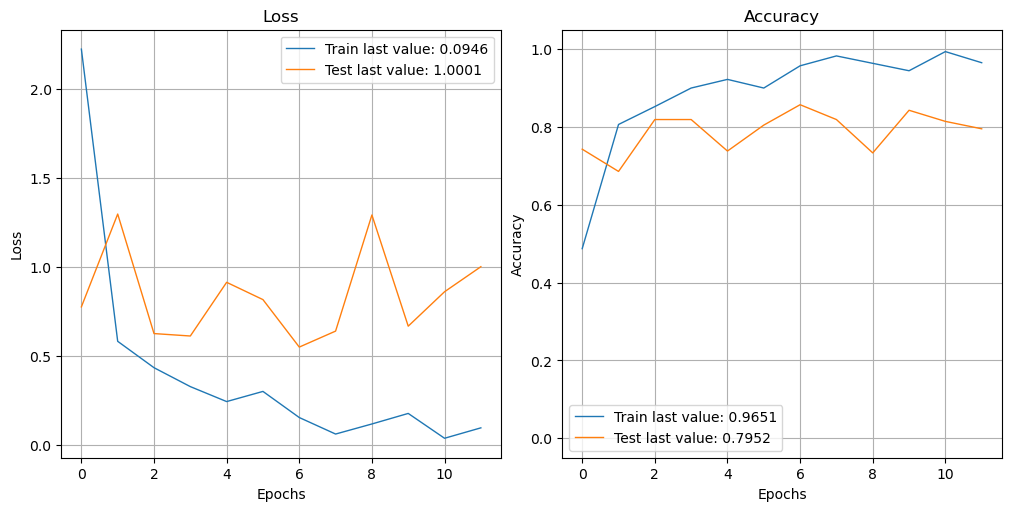

In [73]:
plot_hist(history3)

On collecte l'historique renvoyé par l'entraînement du modèle et on crée deux graphiques : l'un représentant l'accuracy sur les ensembles de données de training et de validation sur les différents epochs, et l'autre similaire mais pour la loss. L'objectif étant pour chaque modèle de maximiser l'accuracy tout en diminuant la loss.

Notre epoch optimal correspond à l'epoch 6 sur les graphiques. On peut constater qu'au delà, le modèle semble être dans un phénomène d'overfitting.

In [74]:
y_val_num = np.argmax(y_val_res, axis=1)
y_val_pred = np.argmax(model3.predict(X_val_res), axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 6s 720ms/step
[0 1 0 0 2 2 3 5 5 2 3 2 2 5 2 2 5 4 4 6 5 4 5 3 3 2 3 3 6 5 6 5 6 6 2 6 4
 6 5 4 0 0 3 5 6 6 2 5 4 6 0 1 6 1 2 4 1 0 3 3 3 6 5 5 5 1 1 3 3 0 4 1 3 0
 6 2 3 1 2 4 1 4 4 4 1 6 0 0 2 4 0 6 3 4 6 5 2 0 6 0 3 6 0 2 6 0 1 5 1 2 0
 4 5 6 5 5 2 1 6 1 4 4 5 1 4 3 3 2 0 6 5 5 0 2 2 3 5 3 3 2 4 4 3 2 4 3 2 6
 5 6 1 3 3 4 0 0 6 0 1 1 5 3 1 1 1 0 4 6 0 3 1 3 1 4 4 4 1 0 6 4 2 2 1 2 6
 0 5 5 1 4 5 5 3 2 2 3 0 5 2 3 1 2 5 1 0 5 6 1 4 1]

[0 1 0 0 2 2 0 5 5 2 3 2 2 5 2 2 3 4 4 6 5 4 5 3 3 2 3 3 6 5 6 5 6 6 2 6 4
 6 5 4 0 4 3 5 6 6 2 5 4 6 0 4 6 1 2 4 1 0 3 3 3 6 5 3 5 1 1 3 3 3 4 2 3 0
 6 2 3 1 2 0 1 4 4 0 2 6 0 0 5 4 0 6 3 4 6 5 2 0 6 0 3 6 0 2 6 0 4 5 1 2 0
 4 5 6 3 5 2 1 6 1 4 4 5 3 4 3 3 2 0 6 5 5 0 6 2 3 5 3 3 2 4 4 3 1 4 3 2 6
 5 6 3 5 3 4 0 0 6 2 1 1 5 3 1 3 1 5 4 6 2 3 1 3 1 4 4 4 1 0 2 4 2 2 1 2 6
 5 2 5 2 4 5 5 0 2 3 3 0 5 2 5 1 2 5 1 0 5 6 2 4 1]


In [75]:
conf_mat3 = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat3)

[[22  0  2  1  1  2  0]
 [ 0 21  4  3  2  0  0]
 [ 0  1 27  1  0  1  1]
 [ 2  0  0 27  0  2  0]
 [ 2  0  0  0 27  0  0]
 [ 0  0  1  3  0 28  0]
 [ 0  0  1  0  0  0 28]]


In [76]:
corresp = 'argmax'
y_val_pred_transform3 = fc.conf_mat_transform(y_val_num, y_val_pred, corresp)
conf_mat3 = metrics.confusion_matrix(y_val_num, y_val_pred_transform3)
print(conf_mat3)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform3))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[22  0  2  1  1  2  0]
 [ 0 21  4  3  2  0  0]
 [ 0  1 27  1  0  1  1]
 [ 2  0  0 27  0  2  0]
 [ 2  0  0  0 27  0  0]
 [ 0  0  1  3  0 28  0]
 [ 0  0  1  0  0  0 28]]

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.95      0.70      0.81        30
           2       0.77      0.87      0.82        31
           3       0.77      0.87      0.82        31
           4       0.90      0.93      0.92        29
           5       0.85      0.88      0.86        32
           6       0.97      0.97      0.97        29

    accuracy                           0.86       210
   macro avg       0.87      0.86      0.86       210
weighted avg       0.86      0.86      0.86       210



<Axes: >

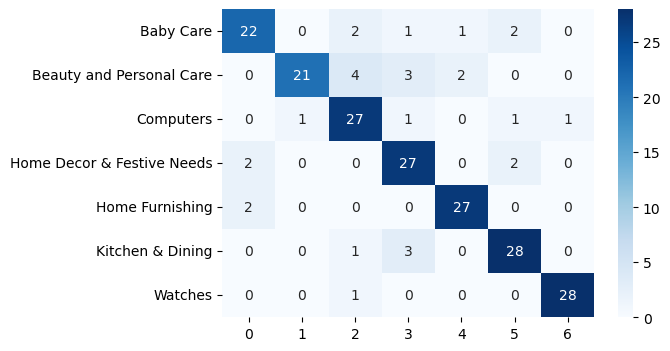

In [77]:
df_cm3 = pd.DataFrame(conf_mat3, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm3, annot=True, cmap="Blues")

On constate que le modèle arrive à prédire relativement bien les catégories. En revanche, il y a des erreurs. Certaines images sont mal catégorisées. Il y a cependant plus d'erreurs que pour le modèle VGG16 pour certaines catégories.

Comparons désormais les différents modèles entraînés afin de sélectionner le plus pertiennt pour notre étude.

In [78]:
tab_models_recap = pd.DataFrame({'Accuracy training':[accuracy_train_vgg, accuracy_train_mob, accuracy_train_res],
                                 'Accuracy validation': [accuracy_val_vgg, accuracy_val_mob, accuracy_val_res],
                                 'Accuracy test': [accuracy_test_vgg, accuracy_test_mob, accuracy_test_res],
                                 'Loss training':[loss_train_vgg, loss_train_mob, loss_train_res],
                                 'Loss validation': [loss_val_vgg, loss_val_mob, loss_val_res],
                                 'Loss test': [loss_test_vgg, loss_test_mob, loss_test_res],
                                 'Temps train': [temps2_train_vgg, temps2_train_mob, temps2_train_res],
                                 'Temps validation': [temps2_val_vgg, temps2_val_mob, temps2_val_res],
                                 'Temps test': [temps2_test_vgg, temps2_test_mob, temps2_test_res]},
                                index = ['VGG16','MobileNet','Resnet50'])

In [79]:
tab_models_recap

,Accuracy training,Accuracy validation,Accuracy test,Loss training,Loss validation,Loss test,Temps train,Temps validation,Temps test
VGG16,0.995238,0.861905,0.780952,0.022656,0.758642,1.028895,364.51,5.44,5.41
MobileNet,0.961905,0.814286,0.804762,0.171082,0.595424,0.585396,63.55,1.93,2.01
Resnet50,0.996825,0.857143,0.838095,0.024403,0.548443,0.598000,204.34,3.84,3.71


On constate que le modèle VGG16 est celui qui offre une meilleure accuracy de validation à 0.86. Nous sélectionnons donc ce modèle pour la suite.

# <a id="4"></a> 4. Optimisation du modèle choisi

Nous allons désormais optimiser certains paramètres du modèle VGG16 afin de tenter d'avoir de meilleures performances.

Nous allons tester différentes valeurs d'*'optimizer'*, de *'loss'* et de *'batch_size'*.

Un optimiseur est un algorithme qui permet de minimiser la fonction de perte (loss function) utilisée dans l'apprentissage d'un modèle. L'optimiseur va ajuster les paramètres du modèle en se basant sur la valeur de la fonction de perte et en utilisant des techniques de descente de gradient pour trouver les valeurs qui minimisent la fonction de perte.
Nous allons tester les valeurs suivantes :
- *'rmsprop'* : adapte la taille du pas de gradient à chaque paramètre de manière adaptative, en fonction de l'historique des gradients passés pour ce paramètre.
- *'adam'* (Adaptive Moment Estimation) : Comme RMSprop, Adam utilise une moyenne mobile des gradients pour adapter le taux d'apprentissage de chaque poids. Mais Adam utilise également une moyenne mobile de la racine carrée des carrés antérieurs des gradients, ce qui donne une correction de biais pour les moments de premier ordre et de second ordre. 

La fonction loss est une fonction mathématique qui permet de mesurer l'écart entre les valeurs prédites par le modèle et les valeurs réelles de l'ensemble d'apprentissage. L'objectif est de minimiser cette fonction de perte pour que le modèle puisse apprendre à prédire les bonnes valeurs.
Nous allons tester les valeurs suivantes, qui sont déstinées à un problème de classification multi-classes :
- *'categorical_crossentropy'* : calcule la moyenne des entropies croisées pour chaque paire de vraie classe et de prédiction de classe, où l'entropie croisée est une mesure de la distance entre la distribution de probabilité réelle et la distribution de probabilité prédite.
- *'categorical_hinge'* : similaire à la fonction de perte 'hinge' utilisée pour la classification binaire, mais elle a été étendue à la classification multi-classes en utilisant une méthode appelée "One-vs-All". Elle calcule la différence entre la somme des valeurs prédites pour la classe correcte et la plus grande valeur prédite pour les autres classes plus un terme de marge. Si cette différence est supérieure à zéro, alors la perte sera égale à cette différence. Sinon, la perte sera égale à zéro.

Le batch_size est le nombre d'échantillons (ou d'images) inclus dans une itération d'entraînement du modèle. En d'autres termes, c'est le nombre de données d'entraînement que le modèle va utiliser à chaque étape de la descente de gradient stochastique pour mettre à jour les poids.
Nous testons les valeurs 32, 64 et 128.

In [12]:
# Séparation du jeu de données en jeu de train et de test
X_train, X_test, y_train, y_test = train_test_split(df_cat['image'], df_cat['label'], test_size=0.2, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(840,)
(840,)
(210,)
(210,)


In [13]:
X_train = list(X_train)
X_test = list (X_test)

In [14]:
# Traitement des images pour les rendre exploitables par l'algorithme 
images_np = image_prep_fct(X_train, 'VGG16')
print(images_np.shape)
images_np_test = image_prep_fct(X_test,'VGG16')
print(images_np_test.shape)

(840, 224, 224, 3)


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(210, 224, 224, 3)


In [15]:
X = images_np
y = to_categorical(y_train)

X_test = images_np_test
y_test = to_categorical(y_test)

In [16]:
# Séparation du jeu de train en jeu de train et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)
X_train.shape

(630, 224, 224, 3)

In [17]:
pickle.dump(X_train, open('models/X_train.pkl', 'wb'))
pickle.dump(y_train, open('models/y_train.pkl', 'wb'))
pickle.dump(X_val, open('models/X_val.pkl', 'wb'))
pickle.dump(y_val, open('models/y_val.pkl', 'wb'))
pickle.dump(X_test, open('models/X_test.pkl', 'wb'))
pickle.dump(y_test, open('models/y_test.pkl', 'wb'))

In [14]:
# Création du modèle
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Création du callback
model1_opti_save_path1 = "models/model1_opti_vgg16_best_weights.h5"
checkpoint = ModelCheckpoint(model1_opti_save_path1, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
callbacks_list = [checkpoint, es]

Metal device set to: Apple M2


In [15]:
loss_param = []
batch_param = []
opti_param = []
temps_train = []
temps_val = []
loss_train = []
loss_val = []
accuracy_train = []
accuracy_val = []

np.random.seed(42)

for opti in ['rmsprop','adam']:
    for loss in ['categorical_crossentropy', 'categorical_hinge']:
        for batch_size in [32, 64, 128]:
        
            loss_param.append(loss)
            batch_param.append(batch_size)
            opti_param.append(opti)
        
            model_opti = create_model_fct(model, loss, opti, option = False)

            temps1=time.time()
            
            history_opti = model_opti.fit(X_train, y_train, epochs=50,
                                          callbacks=callbacks_list,
                                          validation_data=(X_val, y_val),
                                          verbose=0
                                         )

            temps2_train_opti = np.round(time.time()-temps1, 2)
            temps_train.append(temps2_train_opti)
        
            model_opti.load_weights(model1_opti_save_path1)

            loss_train_opti, accuracy_train_opti = model_opti.evaluate(X_train, y_train, verbose=False)
            loss_train.append(loss_train_opti)
            accuracy_train.append(accuracy_train_opti)
        
            temps1=time.time()

            loss_val_opti, accuracy_val_opti = model_opti.evaluate(X_val, y_val, verbose=False)
            loss_val.append(loss_val_opti)
            accuracy_val.append(accuracy_val_opti)

            temps2_val_opti = np.round(time.time()-temps1, 2)
            temps_val.append(temps2_val_opti)

            print('Test avec les paramètres {}, {} et {} réalisé.'.format(loss,batch_size,opti))

2023-05-03 21:59:54.806533: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Test avec les paramètres categorical_crossentropy, 32 et rmsprop réalisé.
Test avec les paramètres categorical_crossentropy, 64 et rmsprop réalisé.
Test avec les paramètres categorical_crossentropy, 128 et rmsprop réalisé.
Test avec les paramètres categorical_hinge, 32 et rmsprop réalisé.
Test avec les paramètres categorical_hinge, 64 et rmsprop réalisé.
Test avec les paramètres categorical_hinge, 128 et rmsprop réalisé.
Test avec les paramètres categorical_crossentropy, 32 et adam réalisé.
Test avec les paramètres categorical_crossentropy, 64 et adam réalisé.
Test avec les paramètres categorical_crossentropy, 128 et adam réalisé.
Test avec les paramètres categorical_hinge, 32 et adam réalisé.
Test avec les paramètres categorical_hinge, 64 et adam réalisé.
Test avec les paramètres categorical_hinge, 128 et adam réalisé.


In [16]:
tab_recap_opti = pd.DataFrame({'Accuracy entrainement': accuracy_train,
                               'Accuracy validation': accuracy_val,
                               'Loss entrainement': loss_train,
                               'Loss validation': loss_val,
                               'Temps train': temps_train,
                               'Temps validation': temps_val,
                               'Loss parameter': loss_param,
                               'Batch parameter': batch_param,
                               'Optimizer parameter':opti_param
                              })
tab_recap_opti

,Accuracy entrainement,Accuracy validation,Loss entrainement,Loss validation,Temps train,Temps validation,Loss parameter,Batch parameter,Optimizer parameter
0,0.982540,0.842857,0.052918,0.828884,105.14,2.68,categorical_crossentropy,32,rmsprop
1,0.982540,0.842857,0.052918,0.828884,122.80,2.43,categorical_crossentropy,64,rmsprop
2,0.988889,0.809524,0.040609,0.788297,114.17,2.53,categorical_crossentropy,128,rmsprop
3,0.890476,0.847619,0.212584,0.312606,199.19,2.45,categorical_hinge,32,rmsprop
4,0.890476,0.847619,0.212584,0.312606,217.89,2.43,categorical_hinge,64,rmsprop
5,0.890476,0.847619,0.212584,0.312606,141.04,2.46,categorical_hinge,128,rmsprop
6,0.890476,0.847619,2.473152,3.251688,132.04,2.40,categorical_crossentropy,32,adam
7,0.890476,0.847619,2.473152,3.251688,94.17,2.46,categorical_crossentropy,64,adam
8,0.890476,0.847619,2.473152,3.251688,128.60,2.49,categorical_crossentropy,128,adam
9,0.879365,0.866667,0.237398,0.275355,142.03,2.56,categorical_hinge,32,adam


On selectionne le modèle ayant l'accuracy de validation la plus élevé, la loss de validation la plus faible et le temps d'entraînement le plus court possible. Cela revient donc à sélectionner le modèle avec les paramètres suivants : loss = *'categorical_hinge'*, batch_size = 128, et optimizer = *'adam'*.

In [ ]:
X_train = pickle.load(open('models/X_train.pkl', 'rb'))
y_train = pickle.load(open('models/y_train.pkl', 'rb'))
X_val = pickle.load(open('models/X_val.pkl', 'rb'))
y_val = pickle.load(open('models/y_val.pkl', 'rb'))
X_test = pickle.load(open('models/X_test.pkl', 'rb'))
y_test = pickle.load(open('models/y_test.pkl', 'rb'))

In [18]:
# Création du modèle
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

model_fin = create_model_fct(model, loss='categorical_hinge', opti='adam')

# Création du callback
model_final_save_path1 = "models/model_final_vgg_best_weights.h5"
checkpoint = ModelCheckpoint(model_final_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Metal device set to: Apple M2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (N

In [19]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1=time.time()

history_final = model_fin.fit(X_train, y_train, epochs=50, batch_size=128, 
                      callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

temps2_train_res = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_res))

Epoch 1/50


2023-05-04 11:53:09.254330: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - ETA: 0s - loss: 1.6235 - accuracy: 0.1460
Epoch 1: val_loss improved from inf to 1.40428, saving model to models/model_final_vgg_best_weights.h5
5/5 [==============================] - 23s 5s/step - loss: 1.6235 - accuracy: 0.1460 - val_loss: 1.4043 - val_accuracy: 0.2476
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 1.4314 - accuracy: 0.2587
Epoch 2: val_loss improved from 1.40428 to 1.28958, saving model to models/model_final_vgg_best_weights.h5
5/5 [==============================] - 23s 5s/step - loss: 1.4314 - accuracy: 0.2587 - val_loss: 1.2896 - val_accuracy: 0.3429
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 1.3168 - accuracy: 0.3206
Epoch 3: val_loss improved from 1.28958 to 1.26826, saving model to models/model_final_vgg_best_weights.h5
5/5 [==============================] - 22s 5s/step - loss: 1.3168 - accuracy: 0.3206 - val_loss: 1.2683 - val_accuracy: 0.3524
Epoch 4/50
5/5 [=====================

Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.8841
Epoch 27: val_loss did not improve from 0.27002
5/5 [==============================] - 23s 5s/step - loss: 0.2311 - accuracy: 0.8841 - val_loss: 0.2880 - val_accuracy: 0.8524
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9095
Epoch 28: val_loss did not improve from 0.27002
5/5 [==============================] - 23s 5s/step - loss: 0.1852 - accuracy: 0.9095 - val_loss: 0.3024 - val_accuracy: 0.8381
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.9095
Epoch 29: val_loss did not improve from 0.27002
5/5 [==============================] - 22s 5s/step - loss: 0.1805 - accuracy: 0.9095 - val_loss: 0.2989 - val_accuracy: 0.8524
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.9111
Epoch 30: val_loss did not improve from 0.27002
5/5 [==============================] - 22s 5s/step - lo

In [20]:
pickle.dump(model_fin, open('models/model_fin.pkl', 'wb'))

In [21]:
# Scores du dernier epoch

loss, accuracy = model_fin.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model_fin.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 16s 791ms/step - loss: 0.1427 - accuracy: 0.9286
Training Accuracy: 0.9286

7/7 [==============================] - 5s 755ms/step - loss: 0.2856 - accuracy: 0.8619
Validation Accuracy:  0.8619


In [22]:
# Scores de l'epoch optimal

model_fin.load_weights(model_final_save_path1)

loss_train_fin, accuracy_train_fin = model_fin.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_train_fin))

temps1=time.time()

loss_val_fin, accuracy_val_fin = model_fin.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_fin))

temps2_val_fin = np.round(time.time()-temps1, 2)
print("Temps validation : {} secondes".format(temps2_val_fin))

temps1=time.time()

loss_test_fin, accuracy_test_fin = model_fin.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_fin))

temps2_test_fin = np.round(time.time()-temps1, 2)
print("Temps test : {} secondes".format(temps2_test_fin))

Training Accuracy: 0.9222
Validation Accuracy :  0.8667
Temps validation : 6.13 secondes
Test Accuracy       :  0.7810
Temps test : 5.33 secondes


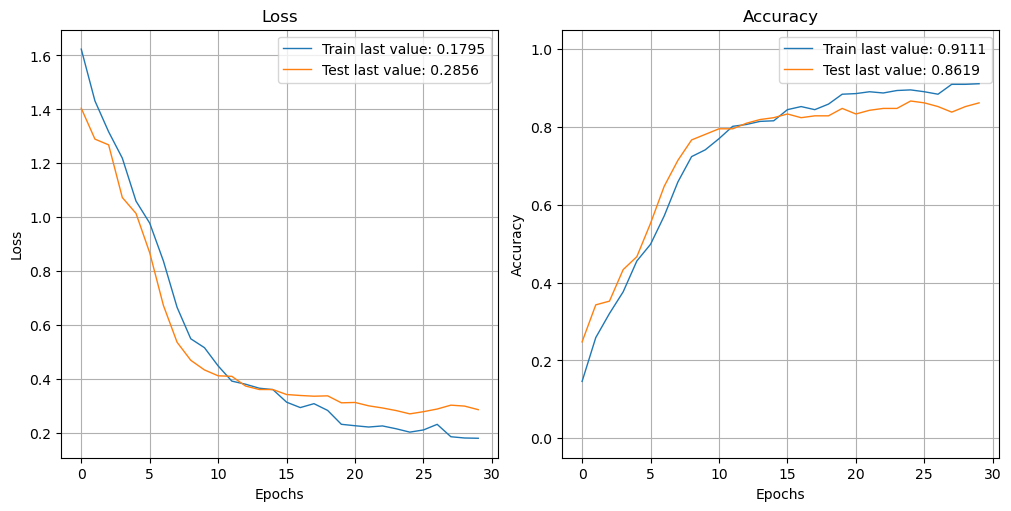

In [23]:
plot_hist(history_final)

On collecte l'historique renvoyé par l'entraînement du modèle et on crée deux graphiques : l'un représentant l'accuracy sur les ensembles de données de training et de validation sur les différents epochs, et l'autre similaire mais pour la loss. L'objectif étant pour chaque modèle de maximiser l'accuracy tout en diminuant la loss.

Notre epoch optimal correspond à l'epoch 24 sur les graphiques. 

In [24]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model_fin.predict(X_val), axis=1)

7/7 [==============================] - 5s 719ms/step


In [25]:
conf_mat_fin = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat_fin)

[[23  0  1  1  2  1  0]
 [ 0 22  4  2  2  0  0]
 [ 0  1 28  1  1  0  0]
 [ 0  0  0 28  1  1  1]
 [ 2  0  0  1 26  0  0]
 [ 0  0  4  2  0 26  0]
 [ 0  0  0  0  0  0 29]]


In [26]:
corresp = 'argmax'
y_val_pred_transform_fin = fc.conf_mat_transform(y_val_num, y_val_pred, corresp)
conf_mat_fin = metrics.confusion_matrix(y_val_num, y_val_pred_transform_fin)
print(conf_mat_fin)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform_fin))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[23  0  1  1  2  1  0]
 [ 0 22  4  2  2  0  0]
 [ 0  1 28  1  1  0  0]
 [ 0  0  0 28  1  1  1]
 [ 2  0  0  1 26  0  0]
 [ 0  0  4  2  0 26  0]
 [ 0  0  0  0  0  0 29]]

              precision    recall  f1-score   support

           0       0.92      0.82      0.87        28
           1       0.96      0.73      0.83        30
           2       0.76      0.90      0.82        31
           3       0.80      0.90      0.85        31
           4       0.81      0.90      0.85        29
           5       0.93      0.81      0.87        32
           6       0.97      1.00      0.98        29

    accuracy                           0.87       210
   macro avg       0.88      0.87      0.87       210
weighted avg       0.88      0.87      0.87       210



<Axes: >

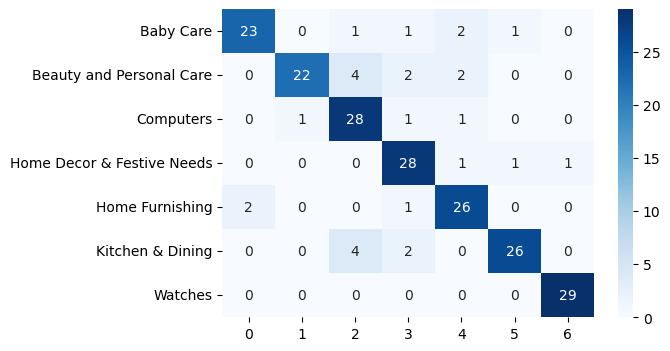

In [27]:
df_cm_fin = pd.DataFrame(conf_mat_fin, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm_fin, annot=True, cmap="Blues")

On constate que le modèle arrive à prédire relativement bien les catégories. En revanche, il y a des erreurs. Certaines images sont mal catégorisées. 

# <a id="5"></a> 5. Data Augmentation

La data augmentation est une technique qui consiste à augmenter artificiellement la taille de l'ensemble de données en appliquant des transformations diverses et aléatoires aux données d'entraînement existantes. Par exemple, pour les images, cela peut inclure la rotation, le recadrage, le redimensionnement, la symétrie horizontale ou verticale, le zoom, le bruit, la luminosité, le contraste, etc.

En augmentant la taille de l'ensemble de données d'entraînement, la data augmentation peut aider à réduire l'overfitting. En effet, elle expose le modèle à une plus grande variété de données, ce qui l'oblige à apprendre des caractéristiques plus générales et plus robustes qui peuvent être appliquées à de nouvelles données.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_cat['image'], df_cat['label'], test_size=0.2, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(840,)
(840,)
(210,)
(210,)


In [29]:
data = pd.concat([X_train,y_train],axis=1)
data['label'] = data['label'].astype(str)
data_test = pd.concat([X_test,y_test],axis=1)
data_test['label'] = data_test['label'].astype(str)

## <a id="6"></a> 5.1 Images avec rotation

Nous ajoutons une rotation à nos données.

In [30]:
# Création du modèle
batch_size = 128
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_data_rot = create_model_fct(model, loss='categorical_hinge', opti='adam')

# Création du callback
model_data_rot_save_path = "models/model_data_rot_best_weights.h5"
checkpoint = ModelCheckpoint(model_data_rot_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [31]:
# Indication de la transformation désirée et création des nouvelles données.
datagen_train = ImageDataGenerator(rotation_range=30, 
                                   fill_mode='nearest',
                                   validation_split=0.25,
                                   preprocessing_function=vgg16.preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=vgg16.preprocess_input)
test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [32]:
temps1=time.time()

history_rotation = model_data_rot.fit(train_flow, validation_data=val_flow,
                                      batch_size=batch_size, epochs=50, 
                                      callbacks=callbacks_list, verbose=1)

temps2_train_rot = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_rot))

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.5381 - accuracy: 0.1889
Epoch 1: val_loss improved from inf to 1.19269, saving model to models/model_data_rot_best_weights.h5
5/5 [==============================] - 29s 6s/step - loss: 1.5381 - accuracy: 0.1889 - val_loss: 1.1927 - val_accuracy: 0.3667
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 1.2443 - accuracy: 0.3556
Epoch 2: val_loss improved from 1.19269 to 0.83009, saving model to models/model_data_rot_best_weights.h5
5/5 [==============================] - 27s 5s/step - loss: 1.2443 - accuracy: 0.3556 - val_loss: 0.8301 - val_accuracy: 0.5476
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 1.0112 - accuracy: 0.4841
Epoch 3: val_loss improved from 0.83009 to 0.75317, saving model to models/model_data_rot_best_weights.h5
5/5 [==============================] - 28s 6s/step - loss: 1.0112 - accuracy: 0.4841 - val_loss: 0.7532 - val_accuracy: 0.5952
Epoch 4/50
5/5 [=============

5/5 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.8857
Epoch 28: val_loss did not improve from 0.37109
5/5 [==============================] - 27s 5s/step - loss: 0.2224 - accuracy: 0.8857 - val_loss: 0.3838 - val_accuracy: 0.8095
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.8937
Epoch 29: val_loss did not improve from 0.37109
5/5 [==============================] - 27s 6s/step - loss: 0.2238 - accuracy: 0.8937 - val_loss: 0.3796 - val_accuracy: 0.8095
Epoch 29: early stopping
Temps d'entrainement : 797.36 secondes


In [33]:
pickle.dump(model_data_rot, open('models/model_data_rot.pkl', 'wb'))

In [34]:
# Scores du dernier epoch

loss_train, accuracy_train = model_data_rot.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy_train))

loss, accuracy = model_data_rot.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

5/5 [==============================] - 21s 4s/step - loss: 0.1579 - accuracy: 0.9206
Training Accuracy   : 0.9206
2/2 [==============================] - 6s 2s/step - loss: 0.3318 - accuracy: 0.8381
Validation Accuracy :  0.8381


In [35]:
# Scores de l'epoch optimal

model_data_rot.load_weights(model_data_rot_save_path)

loss_train_rot, accuracy_train_rot = model_data_rot.evaluate(train_flow, verbose=False)
print("Training Accuracy   : {:.4f}".format(accuracy_train_rot))

temps1=time.time()
loss_val_rot, accuracy_val_rot = model_data_rot.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_rot))
temps2_val_rot = np.round(time.time()-temps1, 2)
print("Temps de validation : {} secondes".format(temps2_val_rot))

temps1=time.time()
loss_test_rot, accuracy_test_rot = model_data_rot.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_rot))
temps2_test_rot = np.round(time.time()-temps1, 2)
print("Temps de test : {} secondes".format(temps2_test_rot))


Training Accuracy   : 0.9016
Validation Accuracy :  0.8048
Temps de validation : 8.45 secondes


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Accuracy       :  0.7762
Temps de test : 8.54 secondes


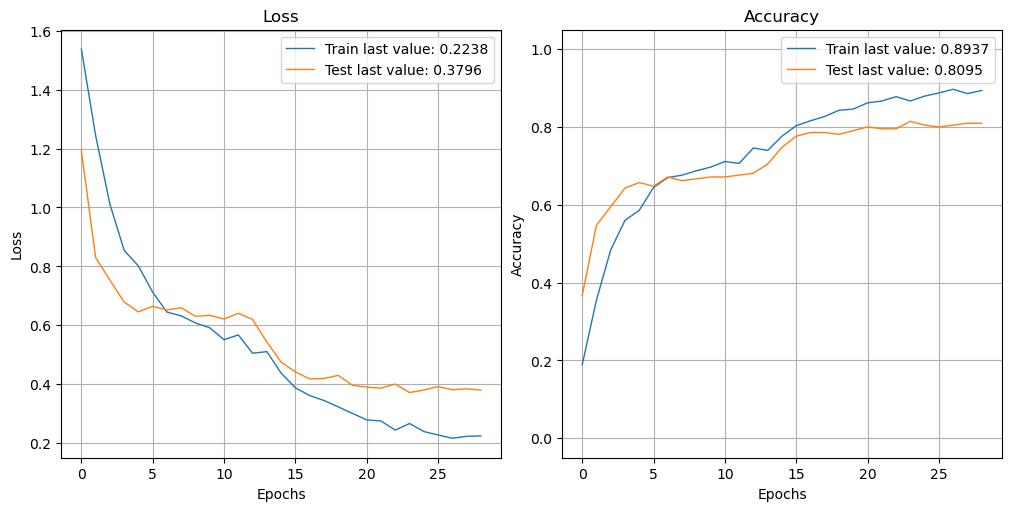

In [36]:
plot_hist(history_rotation)

## <a id="7"></a> 5.2 Images avec shift

Nous ajoutons un décalage à nos données.

In [37]:
# Création du modèle
batch_size = 128
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_data_shift = create_model_fct(model, loss='categorical_hinge', opti='adam')

# Création du callback
model_data_shift_save_path = "models/model_data_shift_best_weights.h5"
checkpoint = ModelCheckpoint(model_data_shift_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [38]:
# Indication de la transformation désirée et création des nouvelles données.
datagen_train = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   validation_split=0.25,
                                   preprocessing_function=vgg16.preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(validation_split=0,
                                  preprocessing_function=vgg16.preprocess_input)
test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [39]:
temps1=time.time()

history_shift = model_data_shift.fit(train_flow, validation_data=val_flow,
                                     batch_size=batch_size, epochs=50, 
                                     callbacks=callbacks_list, verbose=1)

temps2_train_shi = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_shi))

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.5320 - accuracy: 0.1921
Epoch 1: val_loss improved from inf to 1.31737, saving model to models/model_data_shift_best_weights.h5
5/5 [==============================] - 29s 6s/step - loss: 1.5320 - accuracy: 0.1921 - val_loss: 1.3174 - val_accuracy: 0.2905
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 1.2940 - accuracy: 0.3254
Epoch 2: val_loss improved from 1.31737 to 1.14209, saving model to models/model_data_shift_best_weights.h5
5/5 [==============================] - 27s 5s/step - loss: 1.2940 - accuracy: 0.3254 - val_loss: 1.1421 - val_accuracy: 0.4143
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 1.1046 - accuracy: 0.4333
Epoch 3: val_loss improved from 1.14209 to 0.97784, saving model to models/model_data_shift_best_weights.h5
5/5 [==============================] - 27s 5s/step - loss: 1.1046 - accuracy: 0.4333 - val_loss: 0.9778 - val_accuracy: 0.5000
Epoch 4/50
5/5 [=======

5/5 [==============================] - 29s 6s/step - loss: 0.2090 - accuracy: 0.8952 - val_loss: 0.3554 - val_accuracy: 0.8238
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.8857
Epoch 28: val_loss improved from 0.35536 to 0.33880, saving model to models/model_data_shift_best_weights.h5
5/5 [==============================] - 27s 6s/step - loss: 0.2322 - accuracy: 0.8857 - val_loss: 0.3388 - val_accuracy: 0.8190
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9000
Epoch 29: val_loss did not improve from 0.33880
5/5 [==============================] - 27s 6s/step - loss: 0.2077 - accuracy: 0.9000 - val_loss: 0.3493 - val_accuracy: 0.8190
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.8905
Epoch 30: val_loss did not improve from 0.33880
5/5 [==============================] - 27s 6s/step - loss: 0.2167 - accuracy: 0.8905 - val_loss: 0.3964 - val_accuracy: 0.7952
Epoch 31

In [40]:
pickle.dump(model_data_shift, open('models/model_data_shift.pkl', 'wb'))

In [41]:
# Score du dernier epoch

loss_train, accuracy_train = model_data_shift.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy_train))

loss, accuracy = model_data_shift.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

5/5 [==============================] - 20s 4s/step - loss: 0.1492 - accuracy: 0.9222
Training Accuracy   : 0.9222
2/2 [==============================] - 7s 2s/step - loss: 0.3331 - accuracy: 0.8381
Validation Accuracy :  0.8381


In [42]:
# Score de l'epoch optimal

model_data_shift.load_weights(model_data_shift_save_path)

loss_train_shi, accuracy_train_shi = model_data_shift.evaluate(train_flow, verbose=False)
print("Training Accuracy   : {:.4f}".format(accuracy_train_shi))

temps1=time.time()
loss_val_shi, accuracy_val_shi = model_data_shift.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_shi))
temps2_val_shi = np.round(time.time()-temps1, 2)
print("Temps de validation : {} secondes".format(temps2_val_shi))

temps1=time.time()
loss_test_shi, accuracy_test_shi = model_data_shift.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_shi))
temps2_test_shi = np.round(time.time()-temps1, 2)
print("Temps de test : {} secondes".format(temps2_test_shi))

Training Accuracy   : 0.9127
Validation Accuracy :  0.8286
Temps de validation : 8.45 secondes


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Accuracy       :  0.7905
Temps de test : 7.19 secondes


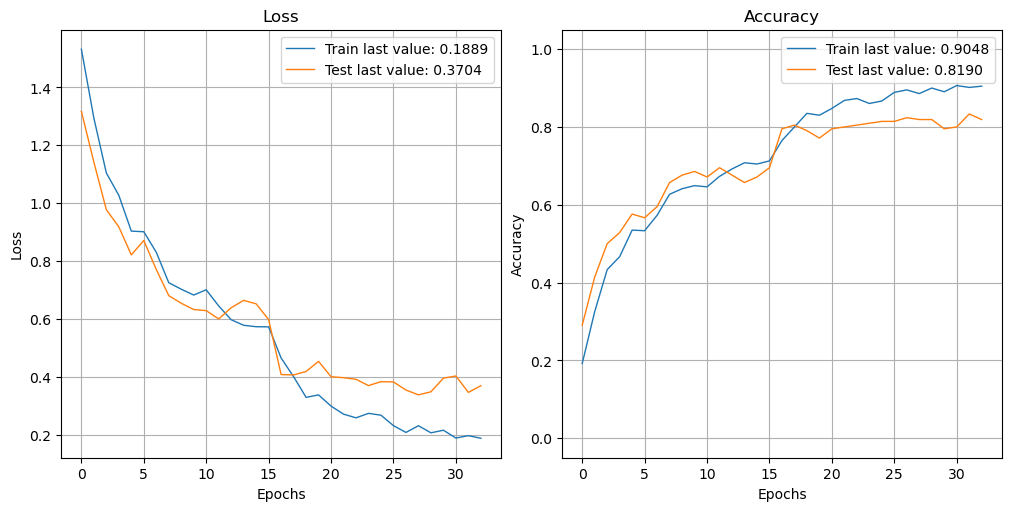

In [43]:
plot_hist(history_shift)

## <a id="8"></a> 5.3 Images avec zoom

Nous ajoutons un zoom à nos données.

In [44]:
# Création du modèle
batch_size = 128
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_data_zoom = create_model_fct(model, loss='categorical_hinge', opti='adam')

# Création du callback
model_data_zoom_save_path = "models/model_data_zoom_best_weights.h5"
checkpoint = ModelCheckpoint(model_data_zoom_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [45]:
# Indication de la transformation désirée et création des nouvelles données.
datagen_train = ImageDataGenerator(zoom_range=0.3,
                                   validation_split=0.25,
                                   preprocessing_function=vgg16.preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=vgg16.preprocess_input)
test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [46]:
temps1=time.time()

history_zoom = model_data_zoom.fit(train_flow, validation_data=val_flow,
                                   batch_size=batch_size, epochs=50, 
                                   callbacks=callbacks_list, verbose=1)

temps2_train_zoom = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_zoom))

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.7091 - accuracy: 0.1127
Epoch 1: val_loss improved from inf to 1.45629, saving model to models/model_data_zoom_best_weights.h5
5/5 [==============================] - 29s 6s/step - loss: 1.7091 - accuracy: 0.1127 - val_loss: 1.4563 - val_accuracy: 0.2381
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 1.4067 - accuracy: 0.2683
Epoch 2: val_loss improved from 1.45629 to 1.09367, saving model to models/model_data_zoom_best_weights.h5
5/5 [==============================] - 27s 6s/step - loss: 1.4067 - accuracy: 0.2683 - val_loss: 1.0937 - val_accuracy: 0.4238
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 1.2617 - accuracy: 0.3444
Epoch 3: val_loss improved from 1.09367 to 1.02782, saving model to models/model_data_zoom_best_weights.h5
5/5 [==============================] - 27s 5s/step - loss: 1.2617 - accuracy: 0.3444 - val_loss: 1.0278 - val_accuracy: 0.4524
Epoch 4/50
5/5 [==========

In [47]:
pickle.dump(model_data_zoom, open('models/model_data_zoom.pkl', 'wb'))

In [48]:
# Scores du dernier epoch

loss_train, accuracy_train = model_data_zoom.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy_train))

loss, accuracy = model_data_zoom.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

5/5 [==============================] - 21s 4s/step - loss: 0.4553 - accuracy: 0.7667
Training Accuracy   : 0.7667
2/2 [==============================] - 6s 2s/step - loss: 0.6578 - accuracy: 0.6619
Validation Accuracy :  0.6619


In [49]:
# Scores de l'epoch optimal

model_data_zoom.load_weights(model_data_zoom_save_path)

loss_train_zoom, accuracy_train_zoom = model_data_zoom.evaluate(train_flow, verbose=False)
print("Training Accuracy   : {:.4f}".format(accuracy_train_zoom))

temps1=time.time()
loss_val_zoom, accuracy_val_zoom = model_data_zoom.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_zoom))
temps2_val_zoom = np.round(time.time()-temps1, 2)
print("Temps de validation : {} secondes".format(temps2_val_zoom))

temps1=time.time()
loss_test_zoom, accuracy_test_zoom = model_data_zoom.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_zoom))
temps2_test_zoom = np.round(time.time()-temps1, 2)
print("Temps de test : {} secondes".format(temps2_test_zoom))

Training Accuracy   : 0.7476
Validation Accuracy :  0.6762
Temps de validation : 8.4 secondes


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Accuracy       :  0.6762
Temps de test : 7.79 secondes


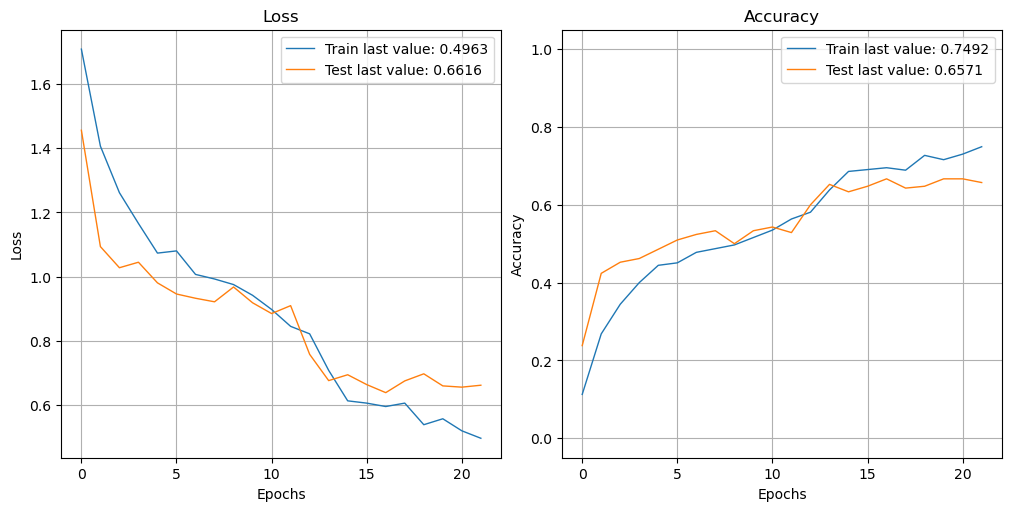

In [50]:
plot_hist(history_zoom)

## <a id="9"></a> 5.4 Images avec plusieurs transformations

Nous testons ici la combinaison des 3 transformations réalisées d'abord séparemment. 

In [51]:
# Création du modèle
batch_size = 128
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_data_gen_all = create_model_fct(model, loss='categorical_hinge', opti='adam')

# Création du callback
model_data_gen_all_save_path = "models/model_data_gen_all_best_weights.h5"
checkpoint = ModelCheckpoint(model_data_gen_all_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [52]:
# Indication de la transformation désirée et création des nouvelles données.
datagen_train = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    validation_split=0.25,
    preprocessing_function=vgg16.preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=vgg16.preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [53]:
temps1=time.time()

history_gen = model_data_gen_all.fit(train_flow, validation_data=val_flow,
                                     batch_size=batch_size, epochs=50, 
                                     callbacks=callbacks_list, verbose=1)

temps2_train_all = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_all))

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.5403 - accuracy: 0.1873
Epoch 1: val_loss improved from inf to 1.25547, saving model to models/model_data_gen_all_best_weights.h5
5/5 [==============================] - 29s 6s/step - loss: 1.5403 - accuracy: 0.1873 - val_loss: 1.2555 - val_accuracy: 0.3143
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 1.3060 - accuracy: 0.3111
Epoch 2: val_loss improved from 1.25547 to 0.96099, saving model to models/model_data_gen_all_best_weights.h5
5/5 [==============================] - 27s 6s/step - loss: 1.3060 - accuracy: 0.3111 - val_loss: 0.9610 - val_accuracy: 0.4952
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 1.0950 - accuracy: 0.4286
Epoch 3: val_loss improved from 0.96099 to 0.84772, saving model to models/model_data_gen_all_best_weights.h5
5/5 [==============================] - 27s 6s/step - loss: 1.0950 - accuracy: 0.4286 - val_loss: 0.8477 - val_accuracy: 0.5762
Epoch 4/50
5/5 [=

In [54]:
pickle.dump(model_data_gen_all, open('models/model_data_gen_all.pkl', 'wb'))

In [55]:
# Score du dernier epoch

loss, accuracy = model_data_gen_all.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model_data_gen_all.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

5/5 [==============================] - 20s 4s/step - loss: 0.2170 - accuracy: 0.8905
Training Accuracy   : 0.8905

2/2 [==============================] - 6s 2s/step - loss: 0.4093 - accuracy: 0.7952
Validation Accuracy :  0.7952


In [56]:
# Score de l'epoch optimal

model_data_gen_all.load_weights(model_data_gen_all_save_path)

loss_train_all, accuracy_train_all = model_data_gen_all.evaluate(train_flow, verbose=False)
print("Training Accuracy   : {:.4f}".format(accuracy_train_all))

temps1=time.time()
loss_val_all, accuracy_val_all = model_data_gen_all.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_all))
temps2_val_all = np.round(time.time()-temps1, 2)
print("Temps de validation : {} secondes".format(temps2_val_all))

temps1=time.time()
loss_test_all, accuracy_test_all = model_data_gen_all.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_all))
temps2_test_all = np.round(time.time()-temps1, 2)
print("Temps de validation : {} secondes".format(temps2_test_all))

Training Accuracy   : 0.8603
Validation Accuracy :  0.8143
Temps de validation : 8.58 secondes


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Accuracy       :  0.7381
Temps de validation : 8.13 secondes


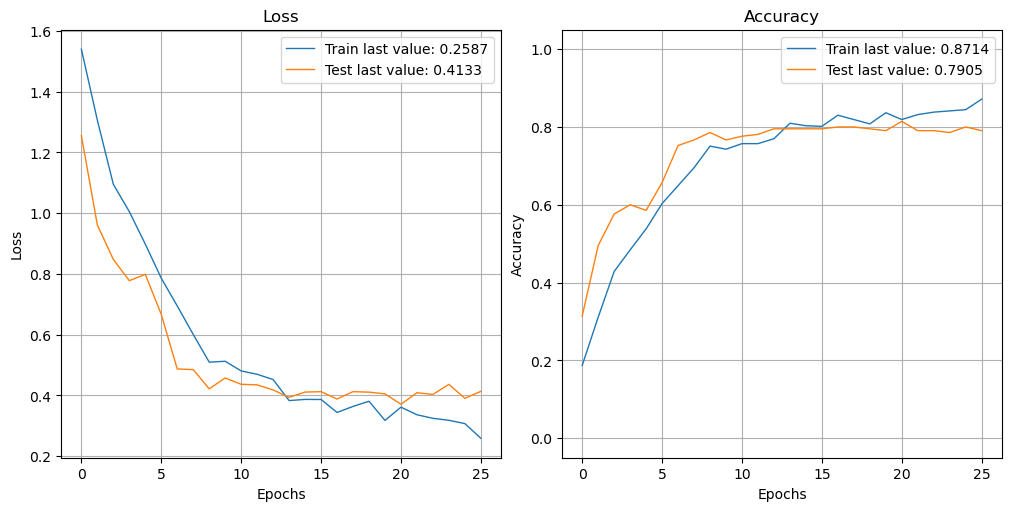

In [57]:
plot_hist(history_gen)

In [58]:
tab_augm_recap = pd.DataFrame({'Accuracy training':[accuracy_train_fin, accuracy_train_rot, accuracy_train_shi, accuracy_train_zoom, accuracy_train_all],
                                 'Accuracy validation': [accuracy_val_fin, accuracy_val_rot, accuracy_val_shi, accuracy_val_zoom, accuracy_val_all],
                                 'Accuracy test': [accuracy_test_fin, accuracy_test_rot, accuracy_test_shi, accuracy_test_zoom, accuracy_test_all],
                                 'Loss training':[loss_train_fin, loss_train_rot, loss_train_shi, loss_train_zoom, loss_train_all],
                                 'Loss validation': [loss_val_fin, loss_val_rot, loss_val_shi, loss_val_zoom, loss_val_all],
                                 'Loss test': [loss_test_fin, loss_test_rot, loss_test_shi, loss_test_zoom, loss_test_all],
                                 'Temps train': [temps2_train_res, temps2_train_rot, temps2_train_shi, temps2_train_zoom, temps2_train_all],
                                 'Temps validation': [temps2_val_fin, temps2_val_rot, temps2_val_shi, temps2_val_zoom, temps2_val_all],
                                 'Temps test': [temps2_test_fin, temps2_test_rot, temps2_test_shi, temps2_test_zoom, temps2_test_all]},
                                index = ['Modèle de base','Rotation','Shift','Zoom','Multiples'])

In [59]:
tab_augm_recap

,Accuracy training,Accuracy validation,Accuracy test,Loss training,Loss validation,Loss test,Temps train,Temps validation,Temps test
Modèle de base,0.922222,0.866667,0.780952,0.153307,0.270020,0.430408,678.94,6.13,5.33
Rotation,0.901587,0.804762,0.776190,0.197698,0.370873,0.440603,797.36,8.45,8.54
Shift,0.912698,0.828571,0.790476,0.173076,0.336404,0.413033,910.84,8.45,7.19
Zoom,0.747619,0.676190,0.676190,0.485336,0.634707,0.634722,605.79,8.40,7.79
Multiples,0.860317,0.814286,0.738095,0.271358,0.377210,0.515449,715.85,8.58,8.13


On constate ici qu'aucun type de data augmentation n'améliore l'accuracy de validation par rapport au modèle de base.